# CSC421 Assignment 1 Search, and CSP 

This assignment notebook explores topics covered in **Chapter 3 - Searching** and **Chapter 6 - Constraint Satisfication Problems** from the book *Artificial Intelligence: A Modern Approach.* The code provided is based on parts of the aima-code repository but has been adapted, modified and simplified for the purposes of the assignment. The notebook is self-contained and other than importing a few common packages you don't need to access any additional code. 

You are welcome (and actually it can be educational) to look at the code at the aima-code repository as well as other code resources you can find on the web or ask ChatGPT. However, make sure you understand any code that you incoporate and submit. A random subset of students will be examined in person and will be asked questions about the code submitted. Failure to understand submitted code will result in a 0 grade for the entire assignment. 

The assignment structure is as follows - each item is worth 1 point: 

 
1. Search (Basic) -  Add connection to Romania map, return frontier evolution as list 
2. Search (Basic) -  Return frontier evolution as list 
3. Search (Expected) - RandomSearch  
4. Search (Expected) - Change grid problem to 4 directions and modulo movement 
5. Search (Expected) - Landgrid problem 
6. Search (Expected) - Manhattan distance  
7. Search (Advanced) Experimental comparison/new heuristic or visualization/animation 
8. CSP (Basic): Basic CSP for map of Australia with unitary contraint  
9. CSP (Expected): Type inference toy example as CSP  
10. CSP (Advanced): Implement CSP as a search problem or more complete type inference   

The assignment is worth $10\%$ of the total grade and each question is worth $1\%$. 

**IMPORTANT:** The submission details will be provided by an announcement through Brightspace and will be through the PraireLearn portal. You 
will be required to submit Python source files individually rather than a notebook for subgroups of the questions 
as this will make grading your solutions easier and faster. For working on the assignment 
I recommend using the jupyter-lab interface as it supports interactive development and it is 
helpful to use visualizations and plots. 




In [1]:
## ABSTRACT PROBLEM CLASS 

%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations

class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When yiou create an instance of a subclass, specify `initial`, and `goal` states 
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
        
    def actions(self, state):        raise NotImplementedError
    def result(self, state, action): raise NotImplementedError
    def is_goal(self, state):        return state == self.goal
    def action_cost(self, s, a, s1): return 1
    def h(self, node):               return 0
    
    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)

class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost
    
failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.
       
def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)
        yield Node(s1, node, action, cost)
        
def path_actions(node):
    "The sequence of actions to get to this node."
    if node.parent is None:
        return []  
    return path_actions(node.parent) + [node.action]

def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None): 
        return []
    return path_states(node.parent) + [node.state]

In [2]:
# PriorityQueue - note 
# there is a small difference from the 
# book implementation in order to ensure 
# sorting stability 

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x): 
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        self.item_count = 0 
        for item in items:
            self.add(item)
         
    def add(self, item):
        """Add item to the queuez."""
        pair = ((self.key(item),self.item_count), item)
        heapq.heappush(self.items, pair)
        self.item_count+=1  

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]
    
    def top(self): return self.items[0][1]

    def get_items(self): 
        return self.items.copy() 

    def __len__(self): return len(self.items)

In [3]:
# Different search algorithms 
# defined by appropriate definition of priorities 


def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    frontiers = [] 
    while frontier:
        frontier_items = frontier.get_items()
        frontiers.append(frontier_items)
        node = frontier.pop()
        
        if problem.is_goal(node.state):
            return (node,reached,frontiers)
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
        
    return (failure, reached, frontiers)

def g(n): return n.path_cost

def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + h(n))
        
def greedy_bfs(problem, h=None):
    """Search nodes with minimum h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=h)

def uniform_cost_search(problem):
    "Search nodes with minimum path cost first."
    return best_first_search(problem, f=g)

def breadth_first_bfs(problem):
    "Search shallowest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=len)


# QUESTION 1 Search (Basic) 1.0 point 

This question looks at how the RouteProblem works using the 
classic map of Romania. Modify the map of Romania specified below by adding a connection from Sibiu to Bucharest with a cost of 280. Run **BreadthFirstSearch** and **UniformCostSearch** search for the pair Arad(initial state) to Bucharest (goal state) for the new map **RomaniaNew** that contains the new added connection and print the solution path and associated for each search algorithm. 

In [4]:
class RouteProblem(Problem):
    """A problem to find a route between locations on a `Map`.
    Create a problem with RouteProblem(start, goal, map=Map(...)}).
    States are the vertexes in the Map graph; actions are destination states."""
    
    def actions(self, state): 
        """The places neighboring `state`."""
        return self.map.neighbors[state]
    
    def result(self, state, action):
        """Go to the `action` place, if the map says that is possible."""
        return action if action in self.map.neighbors[state] else state
    
    def action_cost(self, s, action, s1):
        """The distance (cost) to go from s to s1."""
        return self.map.distances[s, s1]
    
    def h(self, node):
        "Straight-line distance between state and the goal."
        locs = self.map.locations
        return straight_line_distance(locs[node.state], locs[self.goal])
    
    
def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

In [5]:
class Map:
    """A map of places in a 2D world: a graph with vertexes and links between them. 
    In `Map(links, locations)`, `links` can be either [(v1, v2)...] pairs, 
    or a {(v1, v2): distance...} dict. Optional `locations` can be {v1: (x, y)} 
    If `directed=False` then for every (v1, v2) link, we add a (v2, v1) link."""

    def __init__(self, links, locations=None, directed=False):
        if not hasattr(links, 'items'): # Distances are 1 by default
            links = {link: 1 for link in links}
        if not directed:
            for (v1, v2) in list(links):
                links[v2, v1] = links[v1, v2]
        self.distances = links
        self.neighbors = multimap(links)
        self.locations = locations or defaultdict(lambda: (0, 0))

        
def multimap(pairs) -> dict:
    "Given (key, val) pairs, make a dict of {key: [val,...]}."
    result = defaultdict(list)
    for key, val in pairs:
        result[key].append(val)
    return result

In [6]:
# Some specific RouteProblems

romania = Map(
    {('O', 'Z'):  71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118, 
     ('L', 'T'): 111, ('L', 'M'):  70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146, 
     ('C', 'P'): 138, ('R', 'S'):  80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101, 
     ('B', 'G'):  90, ('B', 'U'):  85, ('H', 'U'): 98, ('E', 'H'):  86, ('U', 'V'): 142, 
     ('I', 'V'):  92, ('I', 'N'):  87, ('P', 'R'): 97},
    {'A': ( 76, 497), 'B': (400, 327), 'C': (246, 285), 'D': (160, 296), 'E': (558, 294), 
     'F': (285, 460), 'G': (368, 257), 'H': (548, 355), 'I': (488, 535), 'L': (162, 379),
     'M': (160, 343), 'N': (407, 561), 'O': (117, 580), 'P': (311, 372), 'R': (227, 412),
     'S': (187, 463), 'T': ( 83, 414), 'U': (471, 363), 'V': (535, 473), 'Z': (92, 539)})


r0 = RouteProblem('A', 'A', map=romania)
r1 = RouteProblem('A', 'B', map=romania)
r2 = RouteProblem('N', 'L', map=romania)
r3 = RouteProblem('E', 'T', map=romania)
r4 = RouteProblem('O', 'M', map=romania)
s1, reached, frontiers = uniform_cost_search(r1)
print(path_states(s1))
# the answer should be ['A', 'S', 'R', 'P', 'B']





['A', 'S', 'R', 'P', 'B']


In [7]:
# Q1 ANSWER GOES HERE  

romania = Map(
    {('O', 'Z'):  71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118, 
     ('L', 'T'): 111, ('L', 'M'):  70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146, 
     ('C', 'P'): 138, ('R', 'S'):  80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101, 
     ('B', 'G'):  90, ('B', 'U'):  85, ('H', 'U'): 98, ('E', 'H'):  86, ('U', 'V'): 142, 
     ('I', 'V'):  92, ('I', 'N'):  87, ('P', 'R'): 97, ('S', 'B'): 280, ('B', 'S'): 280},
    {'A': ( 76, 497), 'B': (400, 327), 'C': (246, 285), 'D': (160, 296), 'E': (558, 294), 
     'F': (285, 460), 'G': (368, 257), 'H': (548, 355), 'I': (488, 535), 'L': (162, 379),
     'M': (160, 343), 'N': (407, 561), 'O': (117, 580), 'P': (311, 372), 'R': (227, 412),
     'S': (187, 463), 'T': ( 83, 414), 'U': (471, 363), 'V': (535, 473), 'Z': (92, 539)})


# Create the RouteProblem instances
r_arad_to_bucharest = RouteProblem('A', 'B', map=romania)

# Run Uniform Cost Search
uniform_cost_solution, _, _ = uniform_cost_search(r_arad_to_bucharest)
uniform_cost_path = path_states(uniform_cost_solution)
uniform_cost_cost = uniform_cost_solution.path_cost

# Run Breadth-First Search
bfs_solution, _, _ = breadth_first_bfs(r_arad_to_bucharest)
bfs_path = path_states(bfs_solution)
bfs_cost = bfs_solution.path_cost

# Print the results
print("Uniform Cost Search Path:", uniform_cost_path)
print("Uniform Cost Search Cost:", uniform_cost_cost)
print("Breadth-First Search Path:", bfs_path)
print("Breadth-First Search Cost:", bfs_cost)


Uniform Cost Search Path: ['A', 'S', 'R', 'P', 'B']
Uniform Cost Search Cost: 418
Breadth-First Search Path: ['A', 'S', 'B']
Breadth-First Search Cost: 420


# QUESTION 2 Search (Basic) 1.0 point 

Modify the code of **best_first_search** to return a list of the all the frontiers generated while the search algorithm is running. 
**frontiers** should be a global variable initialized to the empty list when the search algorithm starts running. As the search proceeds the frontier items at each iteration are returned as a list and appended to the **frontiers** list. You can use the **get_items** method of the PriorityQueue to get the current frontier. The number of items/nodes in the frontier correlates to the space complexity (or memory) needed by the algorithm. Output the length of the successive frontiers to see how the space complexity changes over time.   


In [8]:
s1, reached, frontiers = uniform_cost_search(r1)
for f in frontiers: 
    print(len(f))
# the answer should be 
# 1
# 3
# 3
# 3
# 4
# 3
# 4
# 4
# 4
# 4 
# 4
# 3
# 2

1
3
3
3
4
3
4
4
4
4
4
3
2


In [9]:
# Q2 ANSWER GOES HERE (best_first_search with printing of frontier)

def best_first_search(problem, f, frontiers=None):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    frontiers = [] if frontiers is None else frontiers  # Initialize frontiers if not provided
    while frontier:
        frontier_items = frontier.get_items()
        frontiers.append(frontier_items)  # Append the current frontier to the list
        node = frontier.pop()
        
        if problem.is_goal(node.state):
            return (node, reached, frontiers)
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
        
    return (failure, reached, frontiers)



frontiers = []  # Initialize the list to collect frontiers
s1, reached, frontiers = uniform_cost_search(r1)
for f in frontiers:
    print(len(f))

1
3
3
3
4
3
4
4
4
4
4
3
2


# QUESTION 3 Search (Expected) 1.0 point 

Write your own search algorithm called **random_search**. In this search algorithm the node selected for expansion is selected randomly from the frontier (with uniform probability among the possible nodes). Do not modify *best_first_search* but rather 
assign random priorities to each node. Use **random.seed(10.0)** to ensure reproducibility. 

Use the new algorithm to run it for the r1 pair (Arad to Buchararest) on the RomaniaNew map also showing 
how the frontier (not just the length evolves over time). 


In [10]:
# Q3 ANSWER GOES HERE (random_search)

import random

def random_search_f(node):
    "Random priority for nodes."
    return random.random()

def random_search(problem, frontiers=None):
    "Search nodes with minimum f(node) value first using random priorities."
    return best_first_search(problem, f=random_search_f)

frontiers = []  # Initialize the list to collect frontiers
s1, reached, frontiers = random_search(r1, frontiers=frontiers)
for f in frontiers:
    print(f)
# Run the random_search algorithm and get the solution path
solution, _, _ = random_search(r_arad_to_bucharest)
solution_path = path_states(solution)

# Print the solution path
print("Random Search Solution Path:", solution_path)


[((0.7416343778042787, 0), <A>)]
[((0.23449264279518645, 1), <Z>), ((0.894832202714071, 2), <S>), ((0.3452016688154731, 3), <T>)]
[((0.3452016688154731, 3), <T>), ((0.894832202714071, 2), <S>), ((0.3724718291342276, 4), <O>)]
[((0.364907370660311, 5), <L>), ((0.894832202714071, 2), <S>), ((0.3724718291342276, 4), <O>)]
[((0.3724718291342276, 4), <O>), ((0.894832202714071, 2), <S>), ((0.5663453102791653, 6), <M>)]
[((0.5663453102791653, 6), <M>), ((0.894832202714071, 2), <S>)]
[((0.5871165632270613, 7), <D>), ((0.894832202714071, 2), <S>)]
[((0.894832202714071, 2), <S>), ((0.8962565594736692, 8), <C>)]
[((0.21349197260461783, 10), <F>), ((0.8962565594736692, 8), <C>), ((0.7593516251053579, 9), <R>)]
[((0.4760391772307613, 11), <B>), ((0.8962565594736692, 8), <C>), ((0.7593516251053579, 9), <R>)]
Random Search Solution Path: ['A', 'S', 'R', 'P', 'B']


# QUESTION 4 Search (Expected) 1.0 point 

Create a new class of search problems called **GridProblemMod** 
by modifying and renaming the **GridProblem** class below appropriately. The two modifications that you will need to implement in this question are to restrict the directions the agent can move to so that no diagonal movement is allowed i.e only up/right/down/left movement using that order. Unlike the original **GridProblem**, in this case the grid will be finite. Add a parameter to the __init__ method called size that determines the size $N$ of the land grid which is a $N$ by $N$ square. The movement should implement wrap-around using modulo arithmetic i.e if the agent in a grid of size $10$ is in square $(0,5)$ and the action $(-1,5)$ is applied then the agent should move to square $(10,5)$. Another way to think of it is that when the agent reaches the boundary of the land grid they **jump** to the other side. The path shown below demonstrates this wrap-around behavior. 


In [11]:
class GridProblem(Problem):
    """Finding a path on a 2D grid with obstacles. Obstacles are (x, y) cells."""

    def __init__(self, initial=(15, 30), goal=(130, 30), obstacles=(), **kwds):
        Problem.__init__(self, initial=initial, goal=goal, 
                         obstacles=set(obstacles) - {initial, goal}, **kwds)

    directions = [(-1, -1), (0, -1), (1, -1),
                  (-1, 0),           (1,  0),
                  (-1, +1), (0, +1), (1, +1)]
    
    def action_cost(self, s, action, s1): return straight_line_distance(s, s1)
    
    def h(self, node): return straight_line_distance(node.state, self.goal)
                  
    def result(self, state, action): 
        "Both states and actions are represented by (x, y) pairs."
        return action if action not in self.obstacles else state
    
    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
        x, y = state
        return {(x + dx, y + dy) for (dx, dy) in self.directions} - self.obstacles

def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

def transpose(matrix): return list(zip(*matrix))


In [12]:
# question 4 ANSWER GOES HERE 
# add your GridProblemNew class 
# and then check that the code provided works 
# and produces the desired output 
# you can add some check of your own to 
# see how things work 

class GridProblemMod(Problem):
    """Finding a path on a finite 2D grid with obstacles. Obstacles are (x, y) cells."""

    def __init__(self, initial=(0, 0), goal=(0, 0), size=10, obstacles=(), **kwds):
        self.size = size
        Problem.__init__(self, initial=initial, goal=goal,
                         obstacles=set(obstacles) - {initial, goal}, **kwds)

    def action_cost(self, s, action, s1): return straight_line_distance(s, s1)

    def h(self, node):
        return straight_line_distance(node.state, self.goal)

    def result(self, state, action):
        "Both states and actions are represented by (x, y) pairs."
        x, y = action if action not in self.obstacles else state
        # Implementing wrap-around using modulo arithmetic
        x = (x + self.size) % self.size
        y = (y + self.size) % self.size
        return x, y

    def actions(self, state):
        """You can move one cell in the up/right/down/left directions to a non-obstacle cell."""
        x, y = state
        directions = [(0, -1), (1, 0), (0, 1), (-1, 0)]  # Up, Right, Down, Left
        valid_actions = {(x + dx, y + dy) for (dx, dy) in directions} - self.obstacles
        return valid_actions

def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

def transpose(matrix):
    return list(zip(*matrix))



g1 = GridProblemMod(initial = (2,2), goal = (7,6), size=10)
(bfs_g1, reached, frontiers) = breadth_first_bfs(g1)
print(path_states(bfs_g1))
# desired answer 
# [(2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (1, 6), (0, 6), (9, 6), (8, 6), (7, 6)]

[(2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (1, 6), (0, 6), (9, 6), (8, 6), (7, 6)]


# QUESTION 5 Search (Expected) 1.0 point 

Create a new class of search problems called **LandGridProblem** 
by modifying and renaming the **GridProblemMod** class you did in the previous question. 
Each location on the LandGrid has an associated number representing the "cost" of going through 
that location. Grass corresponds to 1, hills correspond to 2, and mountains correspond to 3. 
This is similar to tile-based board games such as Settlers of Catan or computer games such as Civilization. 
Some code for creating, printing, and plotting land grids is provided below. Here is the __init__ 
function you will need to use. 

```
def __init__(self, initial=(2, 2), goal=(4, 4), land_grid=[], **kwds):
    size = len(land_grid)
    Problem.__init__(self, initial=initial, goal=goal,land_grid = land_grid, size = size, **kwds)
```

You will need to modify the action_cost method to take into account the land cost. So if a path contains 
two grass squares, three hills, and one mountain the total path cost will be $2 * 1 + 3 * 2 + 1 * 3 = 10$. 


In [13]:
land_grid1 = [[1,1,2,3,3],[1,2,1,3,1],[1,1,3,1,1],[2,2,2,3,3],[3,1,1,1,1]]
land_grid2 = [[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]]

def create_uniform_land_grid(n): 
    column = [1] * n
    grid = [column] * n 
    return grid 

def create_random_land_grid(n): 
    matrix = [] 
    random.seed(30)
    for i in range(0,n): 
        row = [] 
        for i in range(0,n): 
            row.append(random.randint(1, 3))
        matrix.append(row)
    return matrix 
    
land_grid3 = create_uniform_land_grid(10) 
land_grid4 = create_random_land_grid(10)

print(land_grid4)

[[3, 2, 3, 1, 3, 3, 1, 2, 1, 2], [2, 3, 1, 1, 2, 1, 3, 1, 1, 1], [1, 3, 3, 2, 3, 2, 3, 1, 2, 1], [1, 3, 3, 2, 2, 3, 1, 3, 2, 3], [3, 1, 3, 2, 2, 1, 2, 2, 2, 3], [1, 1, 1, 3, 2, 1, 1, 2, 3, 3], [2, 1, 3, 3, 1, 2, 3, 2, 3, 2], [3, 2, 3, 2, 1, 1, 3, 1, 2, 2], [2, 2, 2, 3, 2, 3, 3, 1, 3, 1], [1, 3, 2, 2, 3, 1, 1, 2, 2, 2]]


In [14]:
# QUESTION 5 ANSWER GOES HERE 

class LandgridProblem(GridProblemMod):
    """Finding a path on a finite 2D land grid with obstacles and varying terrain costs.
    Grass corresponds to 1, hills correspond to 2, and mountains correspond to 3."""
    def __init__(self, initial=(0, 0), goal=(0, 0), land_grid=[], **kwds):
        size = len(land_grid)
        GridProblemMod.__init__(self, initial=initial, goal=goal, size=size, obstacles=[], **kwds)
        self.land_grid = land_grid
    def action_cost(self, s, action, s1):
        """Calculate the cost of an action based on the terrain cost."""
        x, y = action if action not in self.obstacles else s
        # Ensure that the action is within the grid boundaries
        x = (x + self.size) % self.size
        y = (y + self.size) % self.size
        terrain_cost = self.land_grid[x][y]
        return terrain_cost



In [15]:
def plot_grid_problem(grid, solution, reached=(), title='Search', show=True):
    "Use matplotlib to plot the grid, obstacles, solution, and reached."
    grass_points = [] 
    hill_points = [] 
    mountain_points = [] 
    for i in range(0,grid.size): 
        for j in range(0,grid.size): 
            if (grid.land_grid[i][j] == 1): 
                grass_points.append((i,j))
            elif (grid.land_grid[i][j] == 2): 
                hill_points.append((i,j))
            elif (grid.land_grid[i][j] == 3): 
                mountain_points.append((i,j))
    
    nlocations =  grid.size
    plt.figure(figsize=(5, 5))
    plt.axis('on'); 
    plt.xlim((-0.5,nlocations-0.5))
    plt.ylim((-0.5,nlocations-0.5))
    if (grass_points):
        plt.scatter(*transpose(grass_points), (250 / nlocations) **2, marker='s', c='green')
    if (hill_points): 
        plt.scatter(*transpose(hill_points), (250 / nlocations) **2, marker='s', c='yellow')
    if (mountain_points): 
        plt.scatter(*transpose(mountain_points), (250 / nlocations) **2, marker='s', c='black')
    plt.scatter(*transpose(reached), (50/nlocations)**2, marker='o', c='blue')
    plt.scatter(*transpose(path_states(solution)), (100 / nlocations) **2,marker='s', c='red')
    plt.scatter(*transpose([grid.initial]), (125/nlocations)**2, marker='8', c='orange')
    plt.scatter(*transpose([grid.goal]), (125/nlocations)**2, marker='*', c='orange')
    if show: plt.show()
    print('{} {} search: {:.1f} path cost, {:,d} states reached'
          .format(' ' * 10, title, solution.path_cost, len(reached)))

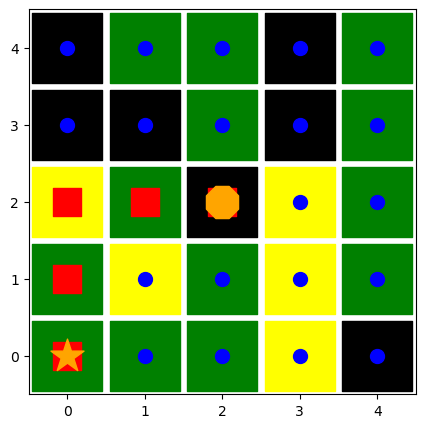

           BFS search: 5.0 path cost, 25 states reached


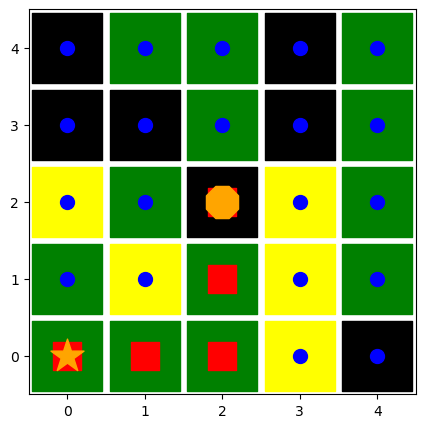

           UniformCost search: 4.0 path cost, 25 states reached


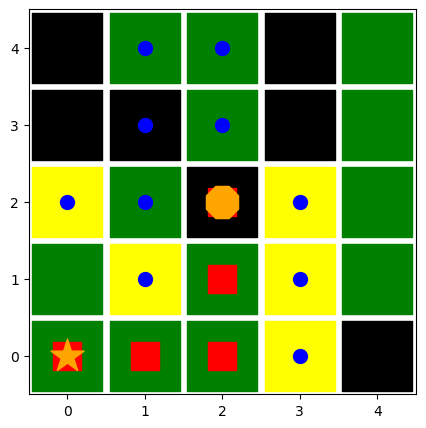

           A* search search: 4.0 path cost, 15 states reached
[(2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (1, 6), (0, 6), (9, 6), (8, 6), (7, 6)]


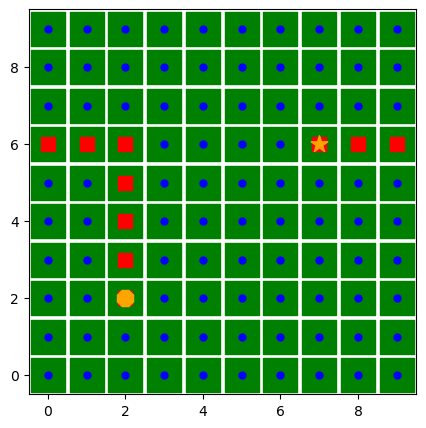

           BFS search: 9.0 path cost, 100 states reached


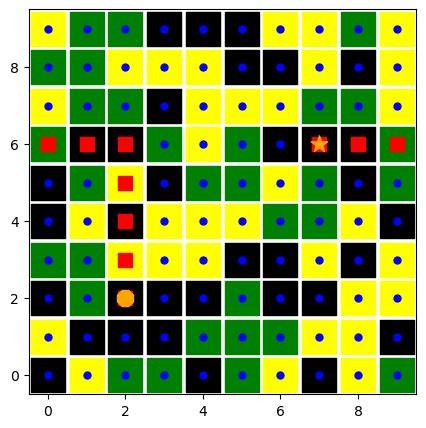

           BFS search: 21.0 path cost, 100 states reached


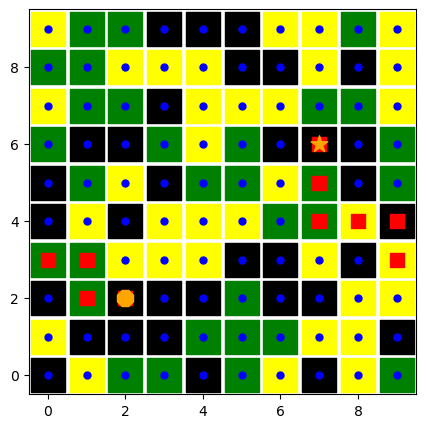

           UCF search: 15.0 path cost, 100 states reached


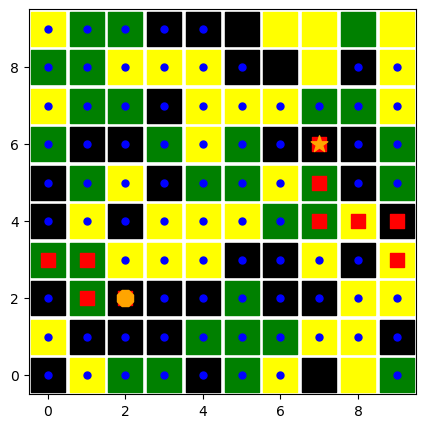

           A* search: 15.0 path cost, 91 states reached


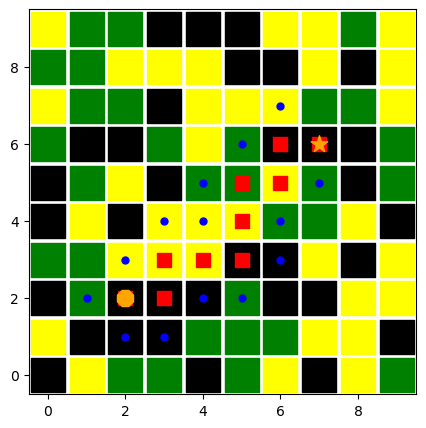

           Greedy search: 21.0 path cost, 24 states reached


In [16]:
# This code will not work until you have implemented appropriately the LandGridProblem class 

d1 = LandgridProblem(initial = (2,2), land_grid = land_grid1)
(bfs_d1, reached, frontiers) = breadth_first_bfs(d1)
plot_grid_problem(d1, bfs_d1, reached, title='BFS', show=True)
(ucs_d1, reached, frontiers) = uniform_cost_search(d1) 
plot_grid_problem(d1, ucs_d1, reached, title='UniformCost', show=True)
(ass_d1, reached, frontiers) = astar_search(d1)
plot_grid_problem(d1, ass_d1, reached, title='A* search', show=True)


d3 = LandgridProblem(initial = (2,2), goal=(7,6), land_grid = land_grid3)
(bfs_d3, reached, frontiers)= breadth_first_bfs(d3)
print(path_states(bfs_d3))
plot_grid_problem(d3, bfs_d3, reached, title='BFS', show=True)


d4 = LandgridProblem(initial = (2,2), goal=(7,6), land_grid = land_grid4)
(bfs_d4, reached, frontiers) = breadth_first_bfs(d4)
plot_grid_problem(d4, bfs_d4, reached, title='BFS', show=True)
(ucs_d4, reached, frontiers) = uniform_cost_search(d4)
plot_grid_problem(d4, ucs_d4, reached, title='UCF', show=True)
(ass_d4, reached, frontiers) = astar_search(d4)
plot_grid_problem(d4, ass_d4, reached, title='A*', show=True)
(grs_d4, reached, frontiers) = greedy_bfs(d4)
plot_grid_problem(d4, grs_d4, reached, title='Greedy', show=True)

# QUESTION 6 SEARCH (EXPECTED) 

The **LandgridProblem** you have implemented uses the straight-line heuristic to guide informed search algorithms. 
Add a **Manhattan distance** heuristic to your implementation. The choice of heuristic should be specified by an argument to the LandGridProblem.

For example: 
```
d4_h1 = LandgridProblem(initial = (2,2), goal=(7,6), land_grid = land_grid4, heuristic='straight')
d4_h2 = LandgridProblem(initial = (2,2), goal=(7,6), land_grid = land_grid4, heuristic='manhattan')
```
The **Manhattan distance** between two points $(x_1, y_1)$ and $(x_2, y_2)$ is defined as $|x_2 - x_1| + |y_2 - y_1|$. 

Show the plots of the solutions to the d4 LandgridProblem instance from the previous questions using the 
$Manhattan distance$ heuristic. 

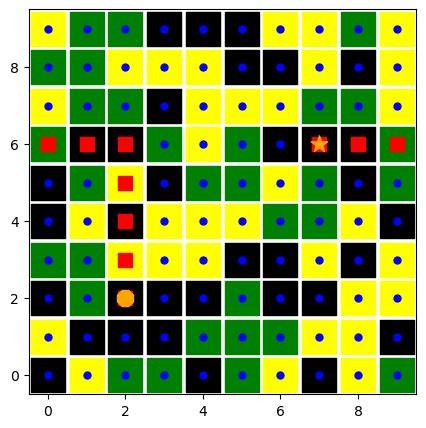

           BFS (Manhattan) search: 21.0 path cost, 100 states reached


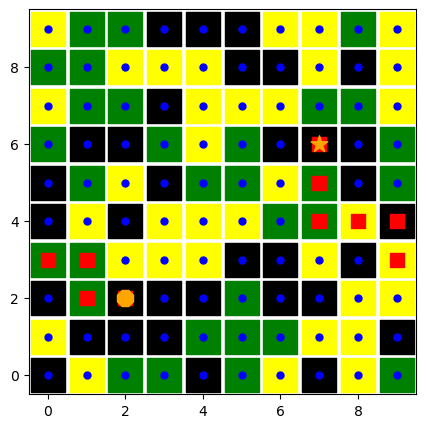

           UCF (Manhattan) search: 15.0 path cost, 100 states reached


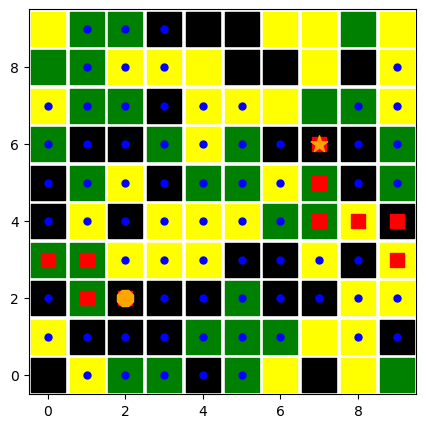

           A* (Manhattan) search: 15.0 path cost, 79 states reached


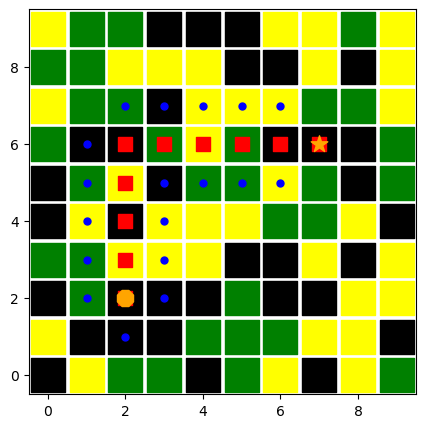

           Greedy (Manhattan) search: 20.0 path cost, 28 states reached


In [17]:
# QUESTION 6 ANSWER GOES HERE 
class LandgridProblem(GridProblemMod):
    """Finding a path on a finite 2D land grid with obstacles and varying terrain costs.
    Grass corresponds to 1, hills correspond to 2, and mountains correspond to 3."""

    def __init__(self, initial=(0, 0), goal=(0, 0), land_grid=[], heuristic='straight', **kwds):
        size = len(land_grid)
        GridProblemMod.__init__(self, initial=initial, goal=goal, size=size, obstacles=[], **kwds)
        self.land_grid = land_grid
        self.heuristic = heuristic

    def h(self, node):
        if self.heuristic == 'manhattan':
            return manhattan_distance(node.state, self.goal)
        else:
            return straight_line_distance(node.state, self.goal)
        
    def action_cost(self, s, action, s1):
        """Calculate the cost of an action based on the terrain cost."""
        x, y = action if action not in self.obstacles else s
        # Ensure that the action is within the grid boundaries
        x = (x + self.size) % self.size
        y = (y + self.size) % self.size
        terrain_cost = self.land_grid[x][y]
        return terrain_cost    

def manhattan_distance(A, B):
    "Manhattan distance between two points."
    return abs(B[1] - A[1]) + abs(B[0] - A[0])

# Example usage
d4_h1 = LandgridProblem(initial=(2, 2), goal=(7, 6), land_grid=land_grid4, heuristic='straight')
d4_h2 = LandgridProblem(initial=(2, 2), goal=(7, 6), land_grid=land_grid4, heuristic='manhattan')

(bfs_d4, reached, frontiers) = breadth_first_bfs(d4_h2)
plot_grid_problem(d4_h2, bfs_d4, reached, title='BFS (Manhattan)', show=True)

(ucs_d4, reached, frontiers) = uniform_cost_search(d4_h2)
plot_grid_problem(d4_h2, ucs_d4, reached, title='UCF (Manhattan)', show=True)

(ass_d4, reached, frontiers) = astar_search(d4_h2)
plot_grid_problem(d4_h2, ass_d4, reached, title='A* (Manhattan)', show=True)

(grs_d4, reached, frontiers) = greedy_bfs(d4_h2)
plot_grid_problem(d4_h2, grs_d4, reached, title='Greedy (Manhattan)', show=True)

# QUESTION 7 SEARCH (Advanced) 1.0 point 

There are two variants of this question. You can implement either one of them or both. The maximum you 
can get is 1 point. 

## VARIANT 1 - Experimental comparison of different search strategies and improving heuristics 

Add random obstacles (similar to the GridProblem in the searching notebook provided by the textbook 
in addition to land types. Neither the straightline heuristic or the Manhattan distance are 
admissable/consistent for the LandgridProblem because they don't take into account the modulo 
wrap-around. See if you can come up with a better heuristic that is admissable - you can use 
search on simpler version of the problem to pre-calculate the heuristic. Do a thorough 
comparison of time complexity (the number of nodes reached), space complexisty (the maximum 
size of the frontier), number of steps, and path cost for 100 random configurations of a 10 by 10 
grid with 100 random initial states, and goals, and random land grids. Also measure the 
time it takes to complete the experiment on your hardware for each search algorithm. Compare the following 
search algorithms by taking the average of all these metrics: breadth-first search, uniform-cost search, 
greedy search, A*-search, and Random Search as well as considering all three heuristics straight-line, 
manahattan, and the one you define. 

## VARIANT 2 - Visualization and animation of search algorithms 

Modify the land-grid plot fuction to show random obstacles (similar to the GridProblem in the 
searching notebook provided by the textbook). Change the code for best-first search so that 
the plotting happens inside the search and show the results of the search incrementally at each 
step. Your first version should generate a single plot for each iteration. Read about how to 
create animation in matplotlib and modify your code so that it can generate an animation that 
shows nicely the evolution of the search algorithm in terms of reached nodes, frontier, etc. 
Don't hesitate to be creative in how this is done. 



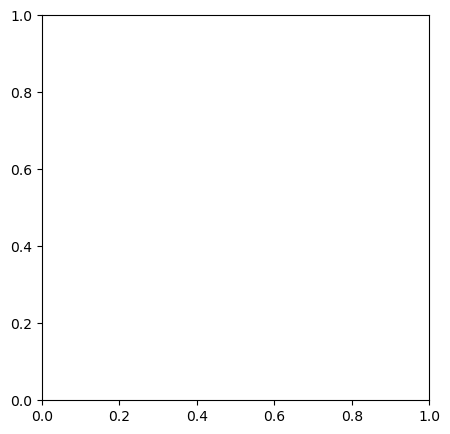

In [18]:

import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation

# Create a figure and axis
fig, ax = plt.subplots(figsize=(5, 5))
    
d4 = LandgridProblem(initial=(2, 2), goal=(7, 6), land_grid=land_grid4)

def best_first_search(frame):
    f = len
    frontiers = None
    
    # Search nodes with minimum f(node) value first.
    node = Node(d4.initial)  # Use d4.initial for the initial node
    frontier = PriorityQueue([node], key=f)
    reached = {d4.initial: node}
    frontiers = [] if frontiers is None else frontiers  # Initialize frontiers if not provided

    while frontier:
        frontier_items = frontier.get_items()
        frontiers.append(frontier_items)  # Append the current frontier to the list
        node = frontier.pop()

        #if d4.is_goal(node.state):
        #    plot_grid_problem(d4, node, reached, title='BFS', show=True)

        for child in expand(d4, node):  # Use d4 for the grid problem
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
                
                # Use ax for plotting
                solution = node
                grid = d4
                grass_points = [] 
                hill_points = [] 
                mountain_points = [] 
                for i in range(0, grid.size): 
                    for j in range(0, grid.size): 
                        if grid.land_grid[i][j] == 1: 
                            grass_points.append((i, j))
                        elif grid.land_grid[i][j] == 2: 
                            hill_points.append((i, j))
                        elif grid.land_grid[i][j] == 3: 
                            mountain_points.append((i, j))

                nlocations = grid.size
                ax.axis('on')
                ax.set_xlim((-0.5, nlocations - 0.5))
                ax.set_ylim((-0.5, nlocations - 0.5))

                if grass_points:
                    ax.scatter(*transpose(grass_points), (250 / nlocations) ** 2, marker='s', c='green')
                if hill_points: 
                    ax.scatter(*transpose(hill_points), (250 / nlocations) ** 2, marker='s', c='yellow')
                if mountain_points: 
                    ax.scatter(*transpose(mountain_points), (250 / nlocations) ** 2, marker='s', c='black')
                ax.scatter(*transpose(reached), (50 / nlocations) ** 2, marker='o', c='blue')
                ax.scatter(*transpose(path_states(solution)), (100 / nlocations) ** 2, marker='s', c='red')
                ax.scatter(*transpose([grid.initial]), (125 / nlocations) ** 2, marker='8', c='orange')
                ax.scatter(*transpose([grid.goal]), (125 / nlocations) ** 2, marker='*', c='orange')
                


# Create the animation using ax and specify the number of frames
ani = FuncAnimation(fig, best_first_search, interval=50,save_count=50)
plt.show()

<IPython.core.display.Javascript object>


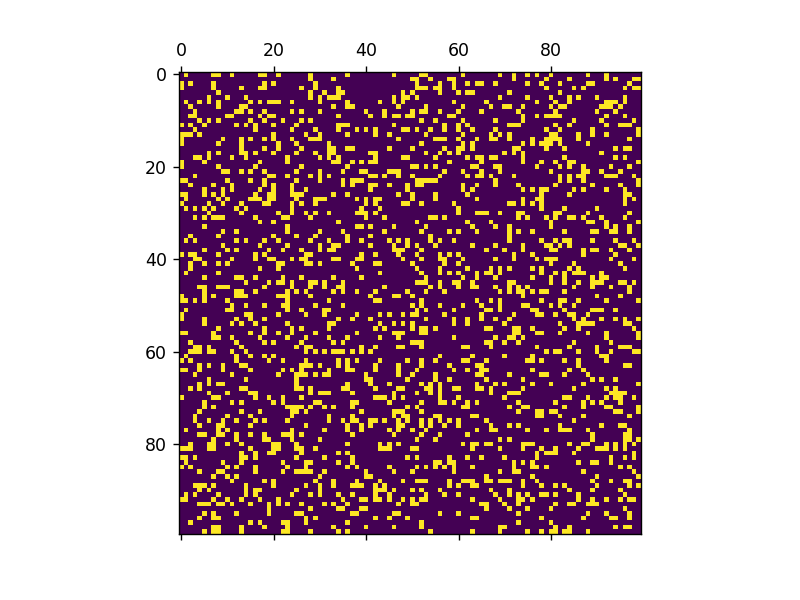

C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [19]:
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt 
import matplotlib.animation as animation

N = 100
ON = 255
OFF = 0
vals = [ON, OFF]

# populate grid with random on/off - more off than on
grid = np.random.choice(vals, N*N, p=[0.2, 0.8]).reshape(N, N)

def update(data):
  global grid
  # copy grid since we require 8 neighbors for calculation
  # and we go line by line 
  newGrid = grid.copy()
  for i in range(N):
    for j in range(N):
      # compute 8-neghbor sum 
      # using toroidal boundary conditions - x and y wrap around 
      # so that the simulaton takes place on a toroidal surface.
      total = (grid[i, (j-1)%N] + grid[i, (j+1)%N] + 
               grid[(i-1)%N, j] + grid[(i+1)%N, j] + 
               grid[(i-1)%N, (j-1)%N] + grid[(i-1)%N, (j+1)%N] + 
               grid[(i+1)%N, (j-1)%N] + grid[(i+1)%N, (j+1)%N])/255
      # apply Conway's rules
      if grid[i, j]  == ON:
        if (total < 2) or (total > 3):
          newGrid[i, j] = OFF
      else:
        if total == 3:
          newGrid[i, j] = ON
  # update data
  mat.set_data(newGrid)
  grid = newGrid
  return [mat]

# set up animation
fig, ax = plt.subplots()
mat = ax.matshow(grid)
ani = animation.FuncAnimation(fig, update, interval=50,
                              save_count=50,blit=True)
plt.show()

<IPython.core.display.Javascript object>


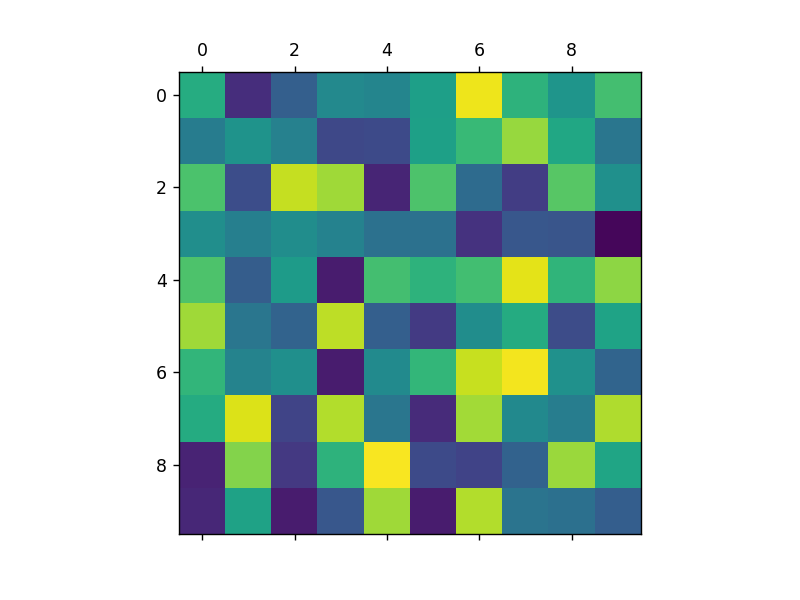

In [20]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

# Create an initial 2D array (matrix)
matrix_size = 10
data = np.random.rand(matrix_size, matrix_size)

# Create a figure and an empty Axes
fig, ax = plt.subplots()
mat = ax.matshow(data, cmap='viridis')  # Create an initial heatmap

# Function to update the animation at each frame
def update(frame):
    # Update the data with a new random 2D array
    new_data = np.random.rand(matrix_size, matrix_size)
    mat.set_data(new_data)  # Update the heatmap data
    return mat,

# Create an animation
ani = FuncAnimation(fig, update, frames=range(100), blit=True)

# Display the animation
plt.show()


# QUESTION 8 CSP (Basic) 1.0 point 


Let's look at a simple basic implemetation of recursive backgtracking search for solving CSP problems. 

In [21]:
def isComplete(assignment):
    return None not in (assignment.values())

def select_unassigned_variable(variables, assignment):
    for var in variables:
        if assignment[var] is None:
            return var

def is_consistent(assignment, constraints):
    for constraint_violated in constraints:
        if constraint_violated(assignment):
          return False
    return True

def init_assignment(csp):
    assignment = {}
    for var in csp["VARIABLES"]:
        assignment[var] = None
    return assignment

def add_constraint(csp, constraint): 
    csp['CONSTRAINTS'].append(constraint)
    
def recursive_backtracking(assignment, csp):
    if isComplete(assignment):
        return assignment
    var = select_unassigned_variable(csp["VARIABLES"], assignment)
    for value in csp["DOMAINS"]:
        assignment[var] = value
        print(f" assigning {var} to {value}")
        if is_consistent(assignment, csp["CONSTRAINTS"]):
            print(f" Done, Assigned {var} to {value}")
            result = recursive_backtracking(assignment, csp)
            if result != "FAILURE":
                return result
        assignment[var] = None
    return "FAILURE"


def binary_constraint(var_pair, violations):
    (v1,v2) = var_pair
    return lambda asmt: (asmt[v1], asmt[v2]) in violations



We can use this implementation to solve the Australia map coloring problem. Before working on this question make sure you understand how the code works. 

1. Print the assignment of variables to values during the recursive backtracking search 
2. Suppose that we want to enforce that Westeran Australia (WA) should be blue in our solution. 
Create an initial assignment to pass as the first argument to the recursive backtracking to achieve that. 
3. Add a unary constraint function. Similarly to binary constraint it should return a function that takes 
as input an assignment and return true if the assignment violates the constraint. Show how this new unary 
constraint can be used to enforce that WA is blue and T is blue in the resulting solution. 

In [22]:
def unary_constraint(variable, values):
    return lambda asmt: asmt[variable] in values


csp1 = {"VARIABLES": ["WA", "NT", "Q", "NSW", "V", "SA", "T"],
        "DOMAINS": ["red", "green", "blue"],
        "CONSTRAINTS": []}

violations = {('red','red'), ('green','green'), ('blue','blue')}

for (v1,v2) in [('WA', 'NT'), ('WA', 'SA'), 
                ('NT', 'SA'), ('NT', 'Q'), 
                ('SA', 'Q'), ('SA', 'NSW'), 
                ('SA', 'V'),('Q', 'NSW'), 
                ('V', 'T')]: 
    add_constraint(csp1, binary_constraint((v1,v2), violations))

#add_constraint(csp1, unary_constraint('WA', ['red','green']))
result = recursive_backtracking(init_assignment(csp1), csp1)
print('Result', result)

 assigning WA to red
 Done, Assigned WA to red
 assigning NT to red
 assigning NT to green
 Done, Assigned NT to green
 assigning Q to red
 Done, Assigned Q to red
 assigning NSW to red
 assigning NSW to green
 Done, Assigned NSW to green
 assigning V to red
 Done, Assigned V to red
 assigning SA to red
 assigning SA to green
 assigning SA to blue
 Done, Assigned SA to blue
 assigning T to red
 assigning T to green
 Done, Assigned T to green
Result {'WA': 'red', 'NT': 'green', 'Q': 'red', 'NSW': 'green', 'V': 'red', 'SA': 'blue', 'T': 'green'}


In [23]:
# Q8 ANSWER GOES HERE (modifications to CSP code and definition)

def unary_constraint(variable, values):
    return lambda asmt: asmt[variable] in values
    


csp1 = {"VARIABLES": ["WA", "NT", "Q", "NSW", "V", "SA", "T"],
        "DOMAINS": ["red", "green", "blue"],
        "CONSTRAINTS": []}

csp2 = {"VARIABLES": ["WA", "NT", "Q", "NSW", "V", "SA", "T"],
        "DOMAINS": ["red", "green", "blue"],
        "CONSTRAINTS": []}

violations = {('red','red'), ('green','green'), ('blue','blue')}

for (v1,v2) in [('WA', 'NT'), ('WA', 'SA'), 
                ('NT', 'SA'), ('NT', 'Q'), 
                ('SA', 'Q'), ('SA', 'NSW'), 
                ('SA', 'V'),('Q', 'NSW'), 
                ('V', 'T')]: 
    add_constraint(csp1, binary_constraint((v1,v2), violations))
    add_constraint(csp2, binary_constraint((v1,v2), violations))
    
add_constraint(csp2, unary_constraint('WA', ['red','green']))

add_constraint(csp1, unary_constraint('WA', ['red','green']))
add_constraint(csp1, unary_constraint('T', ['red','green']))




result2 = recursive_backtracking(init_assignment(csp2), csp2)
print('Result', result2)

result = recursive_backtracking(init_assignment(csp1), csp1)
print('Result', result)


 assigning WA to red
 assigning WA to green
 assigning WA to blue
 Done, Assigned WA to blue
 assigning NT to red
 Done, Assigned NT to red
 assigning Q to red
 assigning Q to green
 Done, Assigned Q to green
 assigning NSW to red
 Done, Assigned NSW to red
 assigning V to red
 Done, Assigned V to red
 assigning SA to red
 assigning SA to green
 assigning SA to blue
 assigning V to green
 Done, Assigned V to green
 assigning SA to red
 assigning SA to green
 assigning SA to blue
 assigning V to blue
 Done, Assigned V to blue
 assigning SA to red
 assigning SA to green
 assigning SA to blue
 assigning NSW to green
 assigning NSW to blue
 Done, Assigned NSW to blue
 assigning V to red
 Done, Assigned V to red
 assigning SA to red
 assigning SA to green
 assigning SA to blue
 assigning V to green
 Done, Assigned V to green
 assigning SA to red
 assigning SA to green
 assigning SA to blue
 assigning V to blue
 Done, Assigned V to blue
 assigning SA to red
 assigning SA to green
 assigning 

# QUESTION 9 CSP (Expected) 1.0 point 

Type inference is used in programming languages to 
infer the type of variables without explicitly stating it. 
Some examples: 
* x = 1  (we can infer x is an integer because 1 is an integer) 
* y = 1.0 (we can infer y is a float because 1.0 is a float) 
* z = x + y (we can infer z is a float because adding a float 
and an integer results in a float)

Constraint satisfaction problem solvers can be used to perform 
type inference. The variables of the programming languages become the variables of the CSP problem, and the domain of each variable is the types it can have. Constraints are created from the expressions analyzed in order to enforce that the assignment of variables to types is correct. Let's consider a simple example: 

* int I 
* float F 
* X = I 
* Y = X + F 
* Z = X + Y
* W = X + I 

We assume that when two variables are connected using assignment then they are the same type. So X is an integer because I has been declared an integer. The type of the result of adding two integers is an integer, the result of adding two floats is a float but the result of adding an integer and a float has type float. So we know that X is an integer and we add F which is a float therefore Y is a float and similarly Z is also a float.  W is an integer because X and I are integers. 

Notice that we did not declare the types of X, Y, and Z but were able to infer them using the semantics of the equality sign and addition. 

Your task for this question is to express this code as a CSP problem and solve it. The result of the CSP will be the inferred types. Each variable (I,F,X,Y,Z,W) will take values from the domain (int, float). Unary constraints can be used for the type declaration and a binary constraint can be used for the assignment expression. You will need to introduce a ternary_constraint method to express the sum expressions. 

In [36]:
# Q9 ANSWER GOES HERE (modifications to CSP code and definition)



# result = recursive_backtracking(init_assignment(csp1), csp1)
# print('Result', result)
# Result {'I': 'int', 'F': 'float', 'X': 'int', 'Y': 'float', 'Z': 'float', 'W': 'int'}

def ternary_constraint(result_var, cont):
    values = []
    if cont[0] == "int" and cont[1] == "int":
        values.append("float")
    elif cont[0] == "int" and cont[1] == "float":
        values.append("int")
    else:
        values.append("int")
    return lambda asmt: asmt[result_var] in values



def infer_types():
    csp = {
        "VARIABLES": ["M", "K", "N", "Y", "Z", "W"],
        "DOMAINS": ["int", "float"],
        "CONSTRAINTS": []
    }
    
    violations = {("int","int","int"), ("float", "float", "float")} 
    
    for (v1, v2) in [('M', 'K'), ('M', 'Y'), ('K', 'N') , ('K', 'W'),('W','Y')]: 
    
        add_constraint(csp, binary_constraint((v1,v2), violations))
        

    # Add binary constraints for assignment expressions
    add_constraint(csp, ternary_constraint("Y", ['int', 'float']))
    add_constraint(csp, ternary_constraint("Z", ['int', 'float']))
    add_constraint(csp, ternary_constraint("W", ['int', 'int']))


    return csp

csp = infer_types()
result = recursive_backtracking(init_assignment(csp), csp)
print('Result', result)

 assigning M to int
 Done, Assigned M to int
 assigning K to int
 Done, Assigned K to int
 assigning N to int
 Done, Assigned N to int
 assigning Y to int
 assigning Y to float
 Done, Assigned Y to float
 assigning Z to int
 assigning Z to float
 Done, Assigned Z to float
 assigning W to int
 Done, Assigned W to int
Result {'M': 'int', 'K': 'int', 'N': 'int', 'Y': 'float', 'Z': 'float', 'W': 'int'}


# QUESTION 10 CSP (Advanced) 1.0 point 

There are two variants of this question. You can implement either one of them or both. The maximum you 
can get is 1 point. 


## VARIANT 1  

Express solving CSP problems as search problems and use the search algorithm code that is provided 
in this notebook to solve the Australia map problem. The specification of the CSP should use the same 
convention as above but you can transform the provided information as needed to use the search algorithm. 
Show how **BFS** and **DFS** can be used to solve the Australia map coloring problem. Important note: your 
approach should be general and allow the solution of any CSP problem with variables, domains, and constraints 
specified as above. It should **NOT** only solve the Australia map.More specifically you will need to write a **CSPProblem** class that takes as input the CSP specification and then appropriately defines the states and the actions so that the generic search algorithms can be applied. 



## VARIANT 2 

Extend the type inference example from question 9. Add a string type and 2 or 3 more functions or operators 
with different type constraints. Write a parser (you can make simplifying assumptions about the syntax 
such as no nested expressions, only single spaces etc) that takes as input toy source code (like the 
one provided in the Question 9 specification), generates the CSP specification, solves the CSP problem 
and return the types of all the variables. That way you don't have to "manually" specify the problem. 


In [25]:
# Q10 answer goes here 
# variant 2

def parse_source_code(source_code):
    Dict = {}
    Exp = {}
    Solu = {}
    parameters = ["string", "float", "int"]
    operator = ["+"]
    csp = {
        "VARIABLES": [],
        "DOMAINS": [],
    }

    for line in source_code.split('\n'):
        line = line.strip()
        if line:
            parts = line.split()
            if len(parts) == 2:
                for i in parts:
                    if i in parameters:
                        csp["DOMAINS"].append(i)
                    else:
                        csp["VARIABLES"].append(i)
                Dict[parts[1]] = parts[0]
                Solu[parts[1]] = parts[0]
            if len(parts) > 2:
                csp["VARIABLES"].append(parts[0])
                Exp[parts[0]]=  ' '.join(parts[2:])
    print(Exp.items())
    for var, expression in Exp.items():
        print(var)
        type_list = []
        variables_in_expression = expression.split()
        for variable in variables_in_expression:
            if variable in Dict and variable not in operator:  # Corrected "elseif" to "elif"
                if Dict[variable] == "int":
                    type_list.append("int")
                elif Dict[variable] == "float":
                    type_list.append("float")
                elif Dict[variable] == "string":
                    type_list.append("string")
        if "string" in type_list:
            Solu[var] = "string"
            Dict[var] = "string"
        elif "float" in type_list and "string" not in type_list:
            Solu[var] = "float"
            Dict[var] = "float"
        elif "int" in type_list and "float" not in type_list and "string" not in type_list:
            Solu[var] = "int"
            Dict[var] = "int"
        #print(type_list)

        
                
    #print(Exp)
    #print(Dict)
    print("Result",Solu)
    return csp

#Feel free to mess around with my source code
source_code = """
int I
float F
string S
X = I
Y = X + F
Z = X + Y
W = X + I
B = S
G = X + B
"""

csp_info = parse_source_code(source_code)
print(csp_info)


dict_items([('X', 'I'), ('Y', 'X + F'), ('Z', 'X + Y'), ('W', 'X + I'), ('B', 'S'), ('G', 'X + B')])
X
Y
Z
W
B
G
Result {'I': 'int', 'F': 'float', 'S': 'string', 'X': 'int', 'Y': 'float', 'Z': 'float', 'W': 'int', 'B': 'string', 'G': 'string'}
{'VARIABLES': ['I', 'F', 'S', 'X', 'Y', 'Z', 'W', 'B', 'G'], 'DOMAINS': ['int', 'float', 'string']}
